In [1]:
print "\n----- Routine for refresh opty scoring -----\n"

import time
ptm_start = time.time()


----- Routine for refresh opty scoring -----



## Global Configuration

In [2]:
# import packages
%pylab inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import graphlab as gl
from graphlab import SFrame
from graphlab import SArray

Populating the interactive namespace from numpy and matplotlib


A newer version of GraphLab Create (v1.9) is available! Your current version is v1.8.5.

You can use pip to upgrade the graphlab-create package. For more information see https://dato.com/products/create/upgrade.


In [3]:
# pandas config

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
pd.set_option('chained_assignment', None)

In [4]:
# global config

glb_config = dict(
    data_dir = 'data', # data folder
    model_dir = 'model', # model folder
    
    # data file info
    data_fn_prefix = 'PROPENSITY_COMMUNITIES_TRAIN_C',
    data_fn_postfix = 'tsv',
    data_fn_sep = '\t',
    
    # label field
    # CUSTOMERFLAG for customer model / PARTNERFLAG for partner model
    label_field = ['CUSTOMERFLAG', 'PARTNERFLAG'],
    
    valid_fn_prefix = 'PROPENSITY_COMMUNITIES_TEST_C',
    
    # model type for customer or partner
    model_type = 'customer', # customer / partner
    model_fn = 'com_ptb.model',
    bucket_fn = 'com_bucket.model'
)

## Training Data Load

In [5]:
# load data

data_fn = glb_config['data_dir'] + '/' + glb_config['data_fn_prefix'] + "." + glb_config['data_fn_postfix']
print "Load raw data from: %s" % data_fn
train_data = pd.read_csv(data_fn, sep = glb_config['data_fn_sep'])
print "Raw data loaded: %d / %d" % (train_data.shape[0], train_data.shape[1])

train_data.head()

Load raw data from: data/PROPENSITY_COMMUNITIES_TRAIN_C.tsv
Raw data loaded: 154125 / 38


,ACCOUNT_ID,AOVBAND,TARGET_MONTH,ORGTYPE,ACCOUNT_AGE_YEARS,SNAP_MONTH_CODE,NON_PORTAL_LICENSES_MEAN,NP_LICENSES_S,NON_PORTAL_USERS_MEAN,NON_PORTAL_USERS_S,NUM_ACT_WORKFLOW_RULES_MEAN,NUM_ACT_WORKFLOW_RULES_S,NUM_DASHBOARDS_MEAN,NUM_DASHBOARDS_S,LCK_EMP_CNT_MEAN,ACT_CHATR_USR_NUM_MEAN,ACT_CHATR_USR_NUM_S,PCT_CHATR_CONTRIB_MEAN,CRUDS_NPUSER,REPORTS_NUM_MEAN,REPORTS_NUM_S,AOV,AOV_D,FTM_OP_TOTAL,TTM_TOTAL_PG,TTM_TOTAL_ACV,PAYDEX,RED_FLAG,SALES_LIC,SERVICE_LIC,PLAT_LIC,TOTAL_LIC,ACT_SELF_SVC_USERS_NUM_AVG,CASES_NUM_AVG,INDUSTRY_NM,FLAG,PARTNERFLAG,CUSTOMERFLAG
0,0013000000M2QKZ,50-200K,72,2,116,72,619.777778,0.222222,8.333333,0.222222,8,0,10,0,112,44,2.2,1,0,-999,0,53701.770000,0.216639,1296,0,0,0,0,208,0,0,208,0,0,-,0,0,0
1,0013000000M2QKZ,50-200K,72,2,116,72,619.777778,0.222222,8.333333,0.222222,8,0,10,0,112,44,2.2,1,0,-999,0,53701.770000,0.216639,1296,0,0,0,0,208,0,0,208,0,0,-,0,0,0
2,0013000000M2QKZ,50-200K,72,2,116,72,619.777778,0.222222,8.333333,0.222222,8,0,10,0,112,44,2.2,1,0,-999,0,53701.770000,0.216639,1296,0,0,0,0,208,0,0,208,0,0,-,0,0,0
3,0013000000M2UUz,50-200K,64,2,115,64,656.444444,-104.622222,42.555556,14.088889,56,NaN,53,20,22,526,205.0,1,0,-999,0,86099.999657,50.096710,0,0,0,0,0,0,0,0,0,0,0,-,0,0,0
4,0013000000M2UUz,50-200K,65,2,115,65,656.444444,-77.883333,46.555556,12.116667,56,NaN,53,15,22,536,163.4,1,0,-999,0,86099.999657,50.096710,0,0,0,0,0,0,0,0,0,0,0,-,0,0,0


## Data Pre-processing
### Target treatment

In [6]:
# specify attribute & target field

if glb_config['model_type'] == 'customer':
    glb_config['label_field'] = 'CUSTOMERFLAG'
    train_data.drop('PARTNERFLAG', axis = 1, inplace = True)
elif glb_config['model_type'] == 'partner':
    glb_config['label_field'] = 'PARTNERFLAG'
    train_data.drop('CUSTOMERFLAG', axis = 1, inplace = True)
else:
    glb_config['label_field'] = ''

train_data.rename(columns = {glb_config['label_field']: 'label'}, inplace = True)
print "Column '%s' used for label" % glb_config['label_field']
print "Raw data after target treatment: %d / %d" % (train_data.shape[0], train_data.shape[1])

Column 'CUSTOMERFLAG' used for label
Raw data after target treatment: 154125 / 37


### ID treatment

In [7]:
data_idx = train_data['ACCOUNT_ID']
train_data.drop('ACCOUNT_ID', axis = 1, inplace = True)
print "Raw data after ID treatment: %d / %d" % (train_data.shape[0], train_data.shape[1])

Raw data after ID treatment: 154125 / 36


### Attribute selection

In [8]:
# show columns left for attribute selection

# train_data.columns.tolist()

In [9]:
model_var_list = ['INDUSTRY_SUMMARY', 'REGION', 'AOVBAND', 'ACCOUNT_AGE_YEARS',
                  'NON_PORTAL_LICENSES_MEAN', 'NP_LICENSES_S', 'NON_PORTAL_LIC_UTIL_MEAN', 'NON_PORTAL_TLP_MEAN',   
                  'NON_PORTAL_USERS_MEAN', 'NON_PORTAL_USERS_S', 'NUM_ACT_WORKFLOW_RULES_MEAN', 'NUM_CUSTOM_APPS_MEAN',
                  'CUSTOM_OBJECTS_NUM_mean', 'CUSTOM_OBJECTS_NUM_S', 'NUM_DASHBOARDS_MEAN', 'LCK_EMP_CNT_MEAN',
                  'APEX_LOC_WRITTEN_MEAN', 'ACT_CHATR_USR_NUM_MEAN', 'ACT_CHATR_USR_NUM_S', 'PCT_CHATR_CONTRIB_MEAN',
                  'CRUDS_NPUSER', 'REPORTS_NUM_MEAN', 'REPORTS_NUM_S', 'AOV_D', 'TTM_TOTAL_PG', 'TTM_TOTAL_ACV', 
                  'CUST_REC_CNT_MEAN', 'STD_REC_CNT_MEAN', 'SALES_LIC', 'SERVICE_LIC', 'ACT_SELF_SVC_USERS_NUM_AVG', 
                  'CASES_NUM_AVG', 'CASES_CRTD_IN_LAST_7D_NUM_AVG']
print "Intersect:"
print set(model_var_list) & set(train_data.columns.tolist())
print "\n"
print "Legacy only:"
print set(model_var_list) - set(train_data.columns.tolist())
print "\n"
print "Replicate only:"
print set(train_data.columns.tolist()) - set(model_var_list)

Intersect:
set(['NUM_ACT_WORKFLOW_RULES_MEAN', 'ACT_SELF_SVC_USERS_NUM_AVG', 'SERVICE_LIC', 'REPORTS_NUM_MEAN', 'CRUDS_NPUSER', 'ACCOUNT_AGE_YEARS', 'ACT_CHATR_USR_NUM_S', 'AOVBAND', 'NON_PORTAL_LICENSES_MEAN', 'SALES_LIC', 'TTM_TOTAL_PG', 'TTM_TOTAL_ACV', 'ACT_CHATR_USR_NUM_MEAN', 'NON_PORTAL_USERS_MEAN', 'REPORTS_NUM_S', 'AOV_D', 'PCT_CHATR_CONTRIB_MEAN', 'NP_LICENSES_S', 'NON_PORTAL_USERS_S', 'LCK_EMP_CNT_MEAN', 'NUM_DASHBOARDS_MEAN', 'CASES_NUM_AVG'])


Legacy only:
set(['NON_PORTAL_LIC_UTIL_MEAN', 'CUSTOM_OBJECTS_NUM_S', 'CASES_CRTD_IN_LAST_7D_NUM_AVG', 'APEX_LOC_WRITTEN_MEAN', 'NON_PORTAL_TLP_MEAN', 'NUM_CUSTOM_APPS_MEAN', 'CUSTOM_OBJECTS_NUM_mean', 'STD_REC_CNT_MEAN', 'CUST_REC_CNT_MEAN', 'INDUSTRY_SUMMARY', 'REGION'])


Replicate only:
set(['TARGET_MONTH', 'RED_FLAG', 'INDUSTRY_NM', 'SNAP_MONTH_CODE', 'NUM_DASHBOARDS_S', 'label', 'FTM_OP_TOTAL', 'AOV', 'FLAG', 'TOTAL_LIC', 'PLAT_LIC', 'NUM_ACT_WORKFLOW_RULES_S', 'ORGTYPE', 'PAYDEX'])


In [10]:
model_var_list = [
    'NUM_ACT_WORKFLOW_RULES_MEAN', 
    'ACT_SELF_SVC_USERS_NUM_AVG', 
    'SERVICE_LIC', 
#     'REPORTS_NUM_MEAN', # commented because of too low variance
#     'CRUDS_NPUSER', # commented because of too low variance
    'ACCOUNT_AGE_YEARS', 
    'ACT_CHATR_USR_NUM_S', 
    'AOVBAND', 
    'NON_PORTAL_LICENSES_MEAN', 
    'SALES_LIC', 
#     'TTM_TOTAL_PG', # commented because of too low variance
#     'TTM_TOTAL_ACV', # commented because of too low variance
    'ACT_CHATR_USR_NUM_MEAN', 
    'NON_PORTAL_USERS_MEAN', 
#     'REPORTS_NUM_S', # commented because of too low variance
    'AOV_D', 
#     'PCT_CHATR_CONTRIB_MEAN', # commented because of too low variance
    'NP_LICENSES_S', 
    'NON_PORTAL_USERS_S', 
    'LCK_EMP_CNT_MEAN', 
    'NUM_DASHBOARDS_MEAN', 
    'CASES_NUM_AVG'
]
model_var_list.append('label')

# for debug only, comment when running on real data
# model_var_list = train_data.columns.values[train_data.columns.values != 'label']

print "Number of variables used for modeling: %d" % (len(model_var_list) - 1) # minus 1 because of label in list

Number of variables used for modeling: 16


## Training & Validation Preparation

In [11]:
# train_data, valid_data = SFrame(train_data).random_split(0.8, seed = 1)
# print "Training data prepared: %d / %d" % (train_data.shape[0], train_data.shape[1])
# print "Validation data prepared: %d / %d" % (valid_data.shape[0], valid_data.shape[1])

## PTB Model Calibration

In [12]:
# select modeling var

train_data = train_data[model_var_list]
print "Training data for modeling: %d / %d" % (train_data.shape[0], train_data.shape[1])
print "Positives vs. Negatives: %d (%.2f%%) vs. %d" % (sum(train_data['label'] == 1), 
                                                       100 * float(sum(train_data['label'] == 1)) / float(len(train_data['label'])),
                                                       sum(train_data['label'] == 0))
train_data.head()

Training data for modeling: 154125 / 17
Positives vs. Negatives: 398 (0.26%) vs. 153727


,NUM_ACT_WORKFLOW_RULES_MEAN,ACT_SELF_SVC_USERS_NUM_AVG,SERVICE_LIC,ACCOUNT_AGE_YEARS,ACT_CHATR_USR_NUM_S,AOVBAND,NON_PORTAL_LICENSES_MEAN,SALES_LIC,ACT_CHATR_USR_NUM_MEAN,NON_PORTAL_USERS_MEAN,AOV_D,NP_LICENSES_S,NON_PORTAL_USERS_S,LCK_EMP_CNT_MEAN,NUM_DASHBOARDS_MEAN,CASES_NUM_AVG,label
0,8,0,0,116,2.2,50-200K,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0
1,8,0,0,116,2.2,50-200K,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0
2,8,0,0,116,2.2,50-200K,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0
3,56,0,0,115,205.0,50-200K,656.444444,0,526,42.555556,50.096710,-104.622222,14.088889,22,53,0,0
4,56,0,0,115,163.4,50-200K,656.444444,0,536,46.555556,50.096710,-77.883333,12.116667,22,53,0,0


In [13]:
# vectorize categorical variables

from sklearn.feature_extraction import DictVectorizer

def one_hot_dataframe(data, cols):
    vec = DictVectorizer()
    
    mk_dict = lambda row: dict((col, row[col]) for col in cols)
    vec.fit(data[cols].apply(mk_dict, axis=1))
    vecData = pd.DataFrame(vec.transform(data[cols].apply(mk_dict, axis=1)).toarray())
    vecData.columns = vec.get_feature_names()
    vecData.index = data.index
    data = data.drop(cols, axis=1)
    data = data.join(vecData)
    
    return (data, vec)

In [14]:
print "Vectorize categorical variables"

cat_var_list = ['AOVBAND']
train_data, hot_encoder = one_hot_dataframe(train_data, cat_var_list)
print "Vectorized training data for modeling: %d / %d" % (train_data.shape[0], train_data.shape[1])
print "Positives vs. Negatives: %d (%.2f%%) vs. %d" % (sum(train_data['label'] == 1), 
                                                       100 * float(sum(train_data['label'] == 1)) / float(len(train_data['label'])),
                                                       sum(train_data['label'] == 0))
train_data.head()

Vectorize categorical variables
Vectorized training data for modeling: 154125 / 19
Positives vs. Negatives: 398 (0.26%) vs. 153727


,NUM_ACT_WORKFLOW_RULES_MEAN,ACT_SELF_SVC_USERS_NUM_AVG,SERVICE_LIC,ACCOUNT_AGE_YEARS,ACT_CHATR_USR_NUM_S,NON_PORTAL_LICENSES_MEAN,SALES_LIC,ACT_CHATR_USR_NUM_MEAN,NON_PORTAL_USERS_MEAN,AOV_D,NP_LICENSES_S,NON_PORTAL_USERS_S,LCK_EMP_CNT_MEAN,NUM_DASHBOARDS_MEAN,CASES_NUM_AVG,label,AOVBAND=200-600K,AOVBAND=50-200K,AOVBAND=More than 600K
0,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,0,1,0
1,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,0,1,0
2,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,0,1,0
3,56,0,0,115,205.0,656.444444,0,526,42.555556,50.096710,-104.622222,14.088889,22,53,0,0,0,1,0
4,56,0,0,115,163.4,656.444444,0,536,46.555556,50.096710,-77.883333,12.116667,22,53,0,0,0,1,0


In [15]:
# re-sampling on positives

from unbalanced_dataset import SMOTE

y = train_data['label']
x = train_data.drop(['label'], axis = 1, inplace = False)

na_val = 0
print "Fill up NA entries with: %f" % na_val
x.fillna(value = na_val, inplace = True)

sample_config = dict(
    ratio = 200, # float(np.count_nonzero(y == 1)) / float(np.count_nonzero(y == 0))
    k = min(400, sum(y == 1) - 1),
    out_step = 0.5, # 0.5 / 1
    kind = 'regular', # 'regular' / 'borderline1' / 'borderline2'
    random_state = 1,
    verbose = True,
)
print "Parameters for positive re-sampling:"
print sample_config
print "\n"

x, y = x.as_matrix(), y.as_matrix()
ptm_process = time.time()
smote = SMOTE(ratio = sample_config['ratio'], k = sample_config['k'], m = sample_config['k'],
              out_step = sample_config['out_step'],
              kind = sample_config['kind'], random_state = sample_config['random_state'],
              verbose = sample_config['verbose'])
syn_x, syn_y = smote.fit_transform(x, y)
print "Re-sampling on positives is done in %f sec" % (time.time() - ptm_process)

train_data_syn = pd.DataFrame(data = syn_x)
col_names = train_data.columns.tolist()
col_names.remove('label')
train_data_syn.columns = col_names
train_data_syn['label'] = syn_y.astype(np.int)

print "\n"
print "Syn training data for modeling: %d / %d" % (train_data_syn.shape[0], train_data_syn.shape[1])
print "Positives vs. Negatives: %d vs. %d" % (sum(train_data_syn['label'] == 1), sum(train_data_syn['label'] == 0))
train_data_syn.head()

Fill up NA entries with: 0.000000
Parameters for positive re-sampling:
{'out_step': 0.5, 'kind': 'regular', 'random_state': 1, 'ratio': 200, 'verbose': True, 'k': 397}


This commercial license of GraphLab Create is assigned to gzhu@salesforce.com.

2016-05-10 15:04:43,443 [INFO] graphlab.cython.cy_server, 176: GraphLab Create v1.8.5 started. Logging: /tmp/graphlab_server_1462917882.log



Determining classes statistics... 2 classes detected: {0: 153727, 1: 398}
Finding the 397 nearest neighbours...done!
Creating synthetic samples...Generated 79600 new samples ...
done!
Re-sampling on positives is done in 2.356562 sec


Syn training data for modeling: 233725 / 19
Positives vs. Negatives: 79998 vs. 153727


,NUM_ACT_WORKFLOW_RULES_MEAN,ACT_SELF_SVC_USERS_NUM_AVG,SERVICE_LIC,ACCOUNT_AGE_YEARS,ACT_CHATR_USR_NUM_S,NON_PORTAL_LICENSES_MEAN,SALES_LIC,ACT_CHATR_USR_NUM_MEAN,NON_PORTAL_USERS_MEAN,AOV_D,NP_LICENSES_S,NON_PORTAL_USERS_S,LCK_EMP_CNT_MEAN,NUM_DASHBOARDS_MEAN,CASES_NUM_AVG,AOVBAND=200-600K,AOVBAND=50-200K,AOVBAND=More than 600K,label
0,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
1,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
2,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
3,56,0,0,115,205.0,656.444444,0,526,42.555556,50.096710,-104.622222,14.088889,22,53,0,0,1,0,0
4,56,0,0,115,163.4,656.444444,0,536,46.555556,50.096710,-77.883333,12.116667,22,53,0,0,1,0,0


In [16]:
# copy training data as syn version

train_data = train_data_syn
model_var_list = train_data.columns.tolist()

print "Synthetic training data for modeling: %d / %d" % (train_data.shape[0], train_data.shape[1])
print "Positives vs. Negatives: %d (%.2f%%) vs. %d" % (sum(train_data['label'] == 1), 
                                                       100 * float(sum(train_data['label'] == 1)) / float(len(train_data['label'])),
                                                       sum(train_data['label'] == 0))
train_data.head()

Synthetic training data for modeling: 233725 / 19
Positives vs. Negatives: 79998 (34.23%) vs. 153727


,NUM_ACT_WORKFLOW_RULES_MEAN,ACT_SELF_SVC_USERS_NUM_AVG,SERVICE_LIC,ACCOUNT_AGE_YEARS,ACT_CHATR_USR_NUM_S,NON_PORTAL_LICENSES_MEAN,SALES_LIC,ACT_CHATR_USR_NUM_MEAN,NON_PORTAL_USERS_MEAN,AOV_D,NP_LICENSES_S,NON_PORTAL_USERS_S,LCK_EMP_CNT_MEAN,NUM_DASHBOARDS_MEAN,CASES_NUM_AVG,AOVBAND=200-600K,AOVBAND=50-200K,AOVBAND=More than 600K,label
0,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
1,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
2,8,0,0,116,2.2,619.777778,208,44,8.333333,0.216639,0.222222,0.222222,112,10,0,0,1,0,0
3,56,0,0,115,205.0,656.444444,0,526,42.555556,50.096710,-104.622222,14.088889,22,53,0,0,1,0,0
4,56,0,0,115,163.4,656.444444,0,536,46.555556,50.096710,-77.883333,12.116667,22,53,0,0,1,0,0


In [17]:
# build ptb model

print "Calibrate PTB model on training data"

na_val = 0
print "Fill up NA entries with: %f" % na_val
train_data.fillna(value = na_val, inplace = True)

model_config = dict(
    max_iterations = 10, 
    max_depth = 6, 
    validation_set = None, # None / 'auto'
    class_weights = None, #'auto', #{1: 1.0 / (float(len(train_data[train_data['label'] == 1])) / float(len(train_data))), 
                     # 0: 1.0 / (float(len(train_data[train_data['label'] != 1])) / float(len(train_data)))}
    verbose = True, 
)
print "Parameters for model calibration:"
print model_config
print "\n"

ptm_process = time.time()

# boosted trees
ptb_model = gl.boosted_trees_classifier.create(dataset = SFrame(train_data), target = 'label',
                                               max_iterations = model_config['max_iterations'],
                                               validation_set = model_config['validation_set'],
                                               class_weights = model_config['class_weights'],
                                               max_depth = model_config['max_depth'],
                                               verbose = model_config['verbose'])

# random forest
# ptb_model = gl.random_forest_classifier.create(dataset = SFrame(train_data), target = 'label',
#                                                validation_set = model_config['validation_set'],
#                                                class_weights = model_config['class_weights'],
#                                                num_trees = 50,
#                                                max_depth = model_config['max_depth'],
#                                                verbose = model_config['verbose'])

print "Model calibration is done in %f sec" % (time.time() - ptm_process)

Calibrate PTB model on training data
Fill up NA entries with: 0.000000
Parameters for model calibration:

Boosted trees classifier:

--------------------------------------------------------

Number of examples          : 233725

Number of classes           : 2

Number of feature columns   : 18

Number of unpacked features : 18

+-----------+--------------+-------------------+-------------------+

| Iteration | Elapsed Time | Training-accuracy | Training-log_loss |

+-----------+--------------+-------------------+-------------------+

| 1         | 0.160623     | 0.958272          | 0.471298          |

| 2         | 0.308682     | 0.961433          | 0.348430          |

| 3         | 0.462219     | 0.963363          | 0.270317          |

| 4         | 0.616950     | 0.964142          | 0.217803          |

| 5         | 0.763153     | 0.964702          | 0.182284          |

| 6         | 0.912028     | 0.966435          | 0.153234          |

| 10        | 1.516245     | 0.973974          | 0.095577          |

+-----------+--------------+-------------------+-------------------+


{'validation_set': None, 'class_weights': None, 'verbose': True, 'max_depth': 6, 'max_iterations': 10}


Model calibration is done in 3.610035 sec


Get variable importance from model
Num. unique variables: 18
Num. total variables: 18


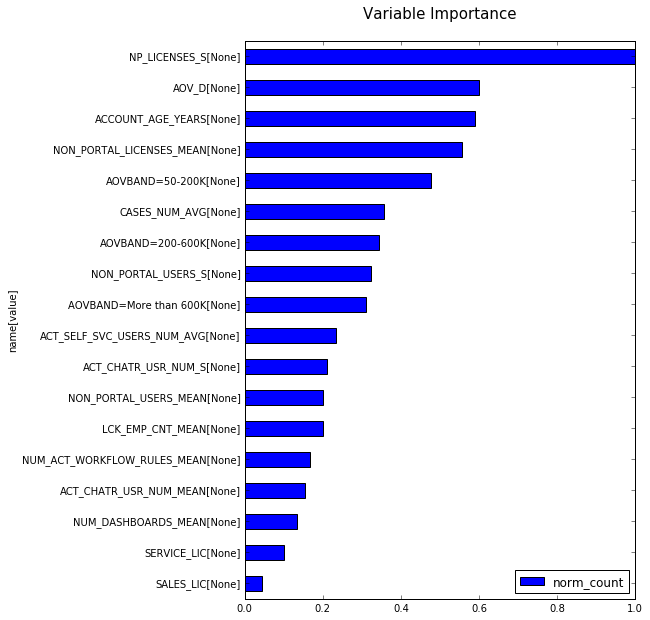

In [18]:
# feature importance

print "Get variable importance from model"

var_importance = ptb_model.get_feature_importance().to_dataframe()
print "Num. unique variables: %d" % len(pd.unique(var_importance['name']))
print "Num. total variables: %d" % len(var_importance['name'])
var_importance.sort_values(by = 'count', ascending = True, inplace = True)

var_importance['name[value]'] = var_importance.apply(lambda x: '%s[%s]' % (x['name'], x['index']), axis = 1)
var_importance['norm_count'] = var_importance['count'].map(lambda x: float(x) / max(var_importance['count']))
var_plt = var_importance.plot(x = 'name[value]', y = 'norm_count', kind = 'barh', figsize = (7, 10))
var_plt.legend(loc = 'lower right')
title('Variable Importance\n', fontsize = 15)

In [19]:
# new "classify" function

def ptb_classify(dataset, model):
    preds = model.classify(dataset = SFrame(dataset))
    preds = preds.to_dataframe()
    preds['proba'] = np.where(preds['class'] == 1, preds['probability'], 1 - preds['probability'])
    return preds

## Bucketing Model Calibration

In [20]:
# quantile regression calibration

def quantile_xy_line(y_prob, y_label):
    quant_step = 0.005
    quants = y_prob.quantile(np.arange(0, 1, quant_step)).values
    # quants = quants[1:] # remove quantile 0

    xline = quants
    yline = [0] * len(xline)

    quants = np.append(quants, 1.0)
    for i in range(len(quants) - 1):
        i_window = y_label[(y_prob > quants[i]) & (y_prob <= quants[i+1])]
        i_pos = sum(i_window > 0)
        if i_pos > 0:
            i_tot = len(i_window)
            yline[i] = float(i_pos) / float(i_tot)
    return dict(xline = xline, yline = yline)

def polynomial_sframe(feature, degree):
    poly_sframe = SFrame()
    poly_sframe['power_1'] = feature
    if degree > 1:
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            poly_sframe[name] = feature.apply(lambda x: x**power)
    return poly_sframe

def quant_bucket_model(y_prob, y_label):
    quant_xy_line = quantile_xy_line(y_prob, y_label)
    xline = quant_xy_line['xline']
    yline = quant_xy_line['yline']
        
    # nonlinear regression via linear regression
    poly_data = polynomial_sframe(feature = SArray(xline), degree = 3)
    poly_data['y'] = yline
    bucket_model = gl.linear_regression.create(dataset = poly_data, target = 'y', 
                                               validation_set = None, verbose = True)
    
    # validate model on training data
#     plt.figure(1)
#     plt.plot(xline, yline, 'ro', xline, bucket_model.predict(poly_data).to_numpy(), 'b-')
#     plt.title('xline vs. yline')
    
#     plt.figure(2)
#     plt.plot(y_prob, bucket_model.predict(polynomial_sframe(feature = SArray(y_prob), degree = 3)).to_numpy(), 'ro')
#     plt.title('y_prob vs. model_predict')
    
    return bucket_model

def prob_bucket_by_quant(proba, bucket_model):
    poly_data = polynomial_sframe(feature = SArray(proba.values), degree = 3)
    bucket_proba = bucket_model.predict(poly_data).to_numpy()
    bucket_proba[bucket_proba < 0] = 0.0
    bucket_proba[bucket_proba > 1] = 1.0
    return bucket_proba

In [21]:
# calibrate new regression model for bucketing

print "Calibrate Bucket model on training data"

train_preds = ptb_classify(dataset = train_data, model = ptb_model)
train_preds['true_class'] = train_data['label']

bucket_model = quant_bucket_model(y_prob = train_preds['proba'], y_label = train_preds['true_class'])

Linear regression:

--------------------------------------------------------

Number of examples          : 200

Number of features          : 3

Number of unpacked features : 3

Number of coefficients    : 4

Starting Newton Method

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

| 1         | 2        | 0.001509     | 0.647990           | 0.246496      |

+-----------+----------+--------------+--------------------+---------------+

## Model Deployment

In [22]:
# deploy model

model_fn = glb_config['model_dir'] + "/" + glb_config['model_type'] + '_' + glb_config['model_fn']
print "Deploy PTB model by 'Pickle-To-File' to: %s" % model_fn
ptb_model.save(model_fn)

bucket_fn = glb_config['model_dir'] + "/" + glb_config['model_type'] + '_' + glb_config['bucket_fn']
print "Deploy Bucket model by 'Pickle-To-File' to: %s" % bucket_fn
bucket_model.save(bucket_fn)

SUCCESS: Optimal solution found.

Deploy PTB model by 'Pickle-To-File' to: model/customer_com_ptb.model
Deploy Bucket model by 'Pickle-To-File' to: model/customer_com_bucket.model


## Model Validation

In [23]:
# validate ptb model on validation data

print "Validate PTB model on validation data"

print "Load PTB model from: %s" % model_fn
valid_ptb_model = gl.load_model(model_fn)

valid_fn = glb_config['data_dir'] + '/' + glb_config['valid_fn_prefix'] + "." + glb_config['data_fn_postfix']
print "Load valid data from: %s" % valid_fn
valid_data = pd.read_csv(valid_fn, sep = glb_config['data_fn_sep'])
print "Valid data loaded: %d / %d\n" % (valid_data.shape[0], valid_data.shape[1])

if glb_config['model_type'] == 'customer':
    glb_config['label_field'] = 'CUSTOMERFLAG'
    valid_data.drop('PARTNERFLAG', axis = 1, inplace = True)
elif glb_config['model_type'] == 'partner':
    glb_config['label_field'] = 'PARTNERFLAG'
    valid_data.drop('CUSTOMERFLAG', axis = 1, inplace = True)
else:
    glb_config['label_field'] = ''
    
valid_data.rename(columns = {glb_config['label_field']: 'label'}, inplace = True)
print "Column '%s' used for label\n" % glb_config['label_field']

valid_data.head()

Validate PTB model on validation data
Load PTB model from: model/customer_com_ptb.model
Load valid data from: data/PROPENSITY_COMMUNITIES_TEST_C.tsv
Valid data loaded: 44835 / 38

Column 'CUSTOMERFLAG' used for label



,ACCOUNT_ID,AOVBAND,TARGET_MONTH,ORGTYPE,ACCOUNT_AGE_YEARS,SNAP_MONTH_CODE,NON_PORTAL_LICENSES_MEAN,NP_LICENSES_S,NON_PORTAL_USERS_MEAN,NON_PORTAL_USERS_S,NUM_ACT_WORKFLOW_RULES_MEAN,NUM_ACT_WORKFLOW_RULES_S,NUM_DASHBOARDS_MEAN,NUM_DASHBOARDS_S,LCK_EMP_CNT_MEAN,ACT_CHATR_USR_NUM_MEAN,ACT_CHATR_USR_NUM_S,PCT_CHATR_CONTRIB_MEAN,CRUDS_NPUSER,REPORTS_NUM_MEAN,REPORTS_NUM_S,AOV,AOV_D,FTM_OP_TOTAL,TTM_TOTAL_PG,TTM_TOTAL_ACV,PAYDEX,RED_FLAG,SALES_LIC,SERVICE_LIC,PLAT_LIC,TOTAL_LIC,ACT_SELF_SVC_USERS_NUM_AVG,CASES_NUM_AVG,INDUSTRY_NM,FLAG,label
0,0013000001CBpgh,50-200K,74,2,116,74,583.600000,0.150000,22.900000,1.030000,81,6.6,14,0.0,420,300,10.3,1,0,-999,0,193488.33600,0.018962,0,0,0,0,0,0,0,0,0,0,2784,-,0,0
1,0013000001CDAIV,50-200K,74,6,116,74,721.125000,0.562500,36.500000,0.950000,65,-0.3,87,1.0,30000,302,6.7,1,0,-999,0,133188.00744,0.200671,0,0,0,0,0,0,0,0,0,0,1,-,0,0
2,0013000000M2mxy,More than 600K,74,6,116,74,86721.214286,-663.668681,18213.928571,4105.331868,514,5.7,5235,90.9,6900,22265,104.2,1,0,-999,0,4454169.23400,0.015558,0,0,0,0,0,0,0,0,0,0,75558,-,0,0
3,00130000002wOJS,50-200K,74,2,116,74,701.875000,0.225000,11.375000,-0.037500,149,15.5,55,3.1,75,193,1.5,1,0,-999,0,71266.20000,0.008354,0,0,0,0,0,0,0,0,0,578,50461,-,0,0
4,0013000000NPlUs,50-200K,74,2,116,74,655.222222,0.000000,34.444444,-0.033333,NaN,NaN,61,4.5,1100,534,3.3,1,0,-999,0,103500.00000,0.000000,0,0,0,0,0,0,0,0,0,0,0,-,0,0


In [24]:
# vectorize categorical variables

from sklearn.feature_extraction import DictVectorizer
def one_hot_encode_valid(data, cols, encoder):  
    mk_dict = lambda row: dict((col, row[col]) for col in cols)
    vecData = pd.DataFrame(encoder.transform(data[cols].apply(mk_dict, axis=1)).toarray())
    vecData.columns = encoder.get_feature_names()
    vecData.index = data.index
    data = data.drop(cols, axis=1)
    data = data.join(vecData)
    
    return data

print "Vectorize categorical variables"

cat_var_list = ['AOVBAND']
valid_data = one_hot_encode_valid(valid_data, cat_var_list, hot_encoder)
print "Vectorized training data for modeling: %d / %d" % (valid_data.shape[0], valid_data.shape[1])
print "Positives vs. Negatives: %d (%.2f%%) vs. %d" % (sum(valid_data['label'] == 1), 
                                                       100 * float(sum(valid_data['label'] == 1)) / float(len(valid_data['label'])),
                                                       sum(valid_data['label'] == 0))
valid_data.head()

Vectorize categorical variables
Vectorized training data for modeling: 44835 / 39
Positives vs. Negatives: 255 (0.57%) vs. 44580


,ACCOUNT_ID,TARGET_MONTH,ORGTYPE,ACCOUNT_AGE_YEARS,SNAP_MONTH_CODE,NON_PORTAL_LICENSES_MEAN,NP_LICENSES_S,NON_PORTAL_USERS_MEAN,NON_PORTAL_USERS_S,NUM_ACT_WORKFLOW_RULES_MEAN,NUM_ACT_WORKFLOW_RULES_S,NUM_DASHBOARDS_MEAN,NUM_DASHBOARDS_S,LCK_EMP_CNT_MEAN,ACT_CHATR_USR_NUM_MEAN,ACT_CHATR_USR_NUM_S,PCT_CHATR_CONTRIB_MEAN,CRUDS_NPUSER,REPORTS_NUM_MEAN,REPORTS_NUM_S,AOV,AOV_D,FTM_OP_TOTAL,TTM_TOTAL_PG,TTM_TOTAL_ACV,PAYDEX,RED_FLAG,SALES_LIC,SERVICE_LIC,PLAT_LIC,TOTAL_LIC,ACT_SELF_SVC_USERS_NUM_AVG,CASES_NUM_AVG,INDUSTRY_NM,FLAG,label,AOVBAND=200-600K,AOVBAND=50-200K,AOVBAND=More than 600K
0,0013000001CBpgh,74,2,116,74,583.600000,0.150000,22.900000,1.030000,81,6.6,14,0.0,420,300,10.3,1,0,-999,0,193488.33600,0.018962,0,0,0,0,0,0,0,0,0,0,2784,-,0,0,0,1,0
1,0013000001CDAIV,74,6,116,74,721.125000,0.562500,36.500000,0.950000,65,-0.3,87,1.0,30000,302,6.7,1,0,-999,0,133188.00744,0.200671,0,0,0,0,0,0,0,0,0,0,1,-,0,0,0,1,0
2,0013000000M2mxy,74,6,116,74,86721.214286,-663.668681,18213.928571,4105.331868,514,5.7,5235,90.9,6900,22265,104.2,1,0,-999,0,4454169.23400,0.015558,0,0,0,0,0,0,0,0,0,0,75558,-,0,0,0,0,1
3,00130000002wOJS,74,2,116,74,701.875000,0.225000,11.375000,-0.037500,149,15.5,55,3.1,75,193,1.5,1,0,-999,0,71266.20000,0.008354,0,0,0,0,0,0,0,0,0,578,50461,-,0,0,0,1,0
4,0013000000NPlUs,74,2,116,74,655.222222,0.000000,34.444444,-0.033333,NaN,NaN,61,4.5,1100,534,3.3,1,0,-999,0,103500.00000,0.000000,0,0,0,0,0,0,0,0,0,0,0,-,0,0,0,1,0


In [25]:
print "Variables used for validation:"
print model_var_list
print "\n"

ptm_process = time.time()
valid_preds = ptb_classify(dataset = valid_data[model_var_list], model = valid_ptb_model)
print "Model validation is done in %f sec" % (time.time() - ptm_process)

Variables used for validation:
['NUM_ACT_WORKFLOW_RULES_MEAN', 'ACT_SELF_SVC_USERS_NUM_AVG', 'SERVICE_LIC', 'ACCOUNT_AGE_YEARS', 'ACT_CHATR_USR_NUM_S', 'NON_PORTAL_LICENSES_MEAN', 'SALES_LIC', 'ACT_CHATR_USR_NUM_MEAN', 'NON_PORTAL_USERS_MEAN', 'AOV_D', 'NP_LICENSES_S', 'NON_PORTAL_USERS_S', 'LCK_EMP_CNT_MEAN', 'NUM_DASHBOARDS_MEAN', 'CASES_NUM_AVG', 'AOVBAND=200-600K', 'AOVBAND=50-200K', 'AOVBAND=More than 600K', 'label']


Model validation is done in 0.333723 sec


Confusion matrix:
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     44580
          1       0.12      0.60      0.20       255

avg / total       0.99      0.97      0.98     44835



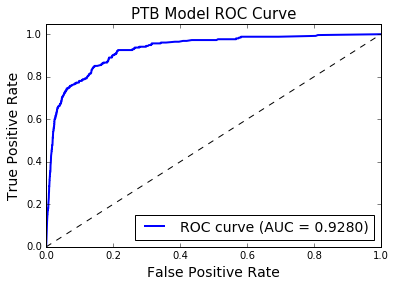

In [26]:
# performance - confusion matrix

true_label = valid_data['label']

from sklearn.metrics import confusion_matrix, classification_report
print "Confusion matrix:"
print classification_report(true_label, valid_preds['class'])

# performance - roc

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(true_label, valid_preds['proba'])
auc = metrics.auc(fpr, tpr)

# Plot of a ROC curve for a specific class
plt.figure(1)
plt.plot(fpr, tpr, label = 'ROC curve (AUC = %0.4f)' % auc, linewidth = 2.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.legend(loc = "lower right", fontsize = 14)
plt.title('PTB Model ROC Curve', fontsize = 15)
plt.show()

In [27]:
# validate bucketing model on validation data

print "Validate Bucket model on validation data"

print "Load Bucket model from: %s" % bucket_fn

print "Bucketing proba via bucket model"
valid_bucket_model = gl.load_model(bucket_fn)
valid_preds['bucket_proba'] = prob_bucket_by_quant(valid_preds['proba'], valid_bucket_model)

bucket_cuts = dict(
    highcut = 0.8,
    mediumcut = 0.5,
    lowcut = 0.3,
)
valid_preds['bucket_level'] = [''] * valid_preds.shape[0]
valid_preds['bucket_level'][(valid_preds['bucket_proba'] >= bucket_cuts['highcut'])] = 'HIGH'
valid_preds['bucket_level'][(valid_preds['bucket_proba'] >= bucket_cuts['mediumcut']) &
                            (valid_preds['bucket_proba'] < bucket_cuts['highcut'])] = 'MEDIUM'
valid_preds['bucket_level'][(valid_preds['bucket_proba'] >= bucket_cuts['lowcut']) &
                            (valid_preds['bucket_proba'] < bucket_cuts['mediumcut'])] = 'LOW'
valid_preds['bucket_level'][(valid_preds['bucket_proba'] < bucket_cuts['lowcut'])] = 'BOTTOM'

Validate Bucket model on validation data
Load Bucket model from: model/customer_com_bucket.model
Bucketing proba via bucket model


In [28]:
# stats on buckets

total_rds = float(len(valid_preds.bucket_level))

num_bkt_rds = (valid_preds.bucket_level == 'HIGH').sum()
print "Num/Pct. HIGH bucket: %d / %.2f" % (num_bkt_rds, num_bkt_rds/total_rds)
num_bkt_rds = (valid_preds.bucket_level == 'MEDIUM').sum()
print "Num/Pct. MEDIUM bucket: %d / %.2f" % (num_bkt_rds, num_bkt_rds/total_rds)
num_bkt_rds = (valid_preds.bucket_level == 'LOW').sum()
print "Num/Pct. LOW bucket: %d / %.2f" % (num_bkt_rds, num_bkt_rds/total_rds)
num_bkt_rds = (valid_preds.bucket_level == 'BOTTOM').sum()
print "Num/Pct. BOTTOM bucket: %d / %.2f" % (num_bkt_rds, num_bkt_rds/total_rds)

Num/Pct. HIGH bucket: 964 / 0.02
Num/Pct. MEDIUM bucket: 676 / 0.02
Num/Pct. LOW bucket: 276 / 0.01
Num/Pct. BOTTOM bucket: 42919 / 0.96


In [29]:
# all done

print "All done " + "in " + str(time.time() - ptm_start) + " sec."

All done in 20.84441185 sec.


In [30]:
a = train_data = pd.read_csv('data/acct_scores.csv', ',')
a.shape
b = a['ACCOUNT_ID']
b.to_csv('data/pb_acct_id.csv', index = False)